### Authors:
Christopher Watson  
Paul Thai

In [18]:
import torch
import os
import cv2 as cv
import imghdr

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import gradio

from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


### Helper Functions + Classes

In [20]:
# Find subfolder contents
def find_subfolder_content_length(path):
  subfolder_length = {}

  for subfolder in os.listdir(path):
    subfolder_path = os.path.join(path,subfolder)

    if os.path.isdir(subfolder_path):
      content_length = len(os.listdir(subfolder_path))
      subfolder_length[subfolder] = content_length

  return subfolder_length

# Displaying some images
def display_sample(batch):
  figure, axis = plt.subplots(ncols = 4, figsize=(15,15))
  for index, image in enumerate(batch[0][:4]):
    axis[index].imshow(image.astype(int))
    axis[index].title.set_text(batch[1][index])

In [21]:
class YogAI:
    """A class to manage the gym steps of people in a real-time video stream based on their poses."""

    def __init__(self):
        """Initializes the AIGym with default values for Visual and Image parameters."""

        # Image and line thickness
        self.im0 = None
        self.tf = None

        # Keypoints and count information
        self.keypoints = None
        self.threshold = 0.001

        # Store stage, count and angle information
        self.angle = None
        self.count = None
        self.yoga_pose = 'standing'
        self.kp_check = None

        # Visuals
        self.view_frame = False
        self.annotator = None

    # Setting our paraemters
    def set_params(self,
                   kp_check,
                   line_thickness=2,
                   view_frame = False,
                   yoga_pose = 'standing'):
        
        self.kp_check = kp_check
        self.tf = line_thickness
        self.view_frame = view_frame
        self.yoga_pose = yoga_pose

    # RT Angles
    def plot_angle(self, 
                   angle_text,
                   command, 
                   center_kpt, 
                   line_thickness=2):
        
        angle_text = f' {angle_text:.2f}'
        font_scale = 0.6 + (line_thickness / 10.0)

        # Draw angle
        (angle_text_width, angle_text_height), _ = cv.getTextSize(angle_text, cv.FONT_HERSHEY_SIMPLEX, font_scale,
                                                                    line_thickness)
        angle_text_position = (int(center_kpt[0]), int(center_kpt[1]))
        angle_background_position = (angle_text_position[0], angle_text_position[1] - angle_text_height - 5)
        angle_background_size = (angle_text_width + 2 * 5, angle_text_height + 2 * 5 + (line_thickness * 2))
        cv.rectangle(self.frame, angle_background_position, (angle_background_position[0] + angle_background_size[0],
                                                            angle_background_position[1] + angle_background_size[1]),
                        (255, 255, 255), -1)
        cv.putText(self.frame, command, angle_text_position, cv.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0),
                line_thickness)

    # Determining the different poses
    def find_pose(self,
                  frame,
                  results,
                  frame_count,
                  full_name):
        self.frame = frame

        if frame_count == 1:
            self.count = [0] * len(results[0])
            self.angle = [0] * len(results[0])
            self.stage = ['-' for _ in results[0]]

        self.keypoints = results[0].keypoints.data
        self.annotator = Annotator(frame, line_width=2)

        temp_angles = {}
        temp_angles['img'] = full_name

        for things in self.kp_check:
            for ind, k in enumerate(reversed(self.keypoints)):

                try:
                    self.angle[ind] = self.annotator.estimate_pose_angle(k[int(things[0])].cpu(),
                                                                            k[int(things[1])].cpu(),
                                                                            k[int(things[2])].cpu())
                    self.im0 = self.annotator.draw_specific_points(k, things, shape=(640, 640), radius=10)

                    temp_angles[things[3]] =  self.angle[ind]

                except:
                    pass
        res_angles =  pd.DataFrame(columns=list(temp_angles.keys()))
        res_angles.loc[0] = list(temp_angles.values())    

        return res_angles
    

    def calibration(self,
                    frame,
                    res_angles,
                    bounding_range,
                    results,
                    frame_count):
        self.frame = frame
        
        if frame_count == 1:
            self.angle = [0] * len(results[0])
        
        self.keypoints = results[0].keypoints.data
        self.annotator = Annotator(frame, line_width=2)

        for things in self.kp_check:
            for ind, k in enumerate(reversed(self.keypoints)):
                try:
                    if self.yoga_pose == 'Virabhadrasana_Two_left': # Define the poses here
                        self.angle[ind] = self.annotator.estimate_pose_angle(k[int(things[0])].cpu(),
                                                                            k[int(things[1])].cpu(),
                                                                            k[int(things[2])].cpu())
                        self.bound_angles(center_kpt=k[int(things[1])],
                                        pos_angle = self.angle[ind],
                                        angles=res_angles,
                                        bounding_range=bounding_range)
                        
                    if self.yoga_pose == 'Virabhadrasana_Two_right': # Define the poses here
                        self.angle[ind] = self.annotator.estimate_pose_angle(k[int(things[0])].cpu(),
                                                                            k[int(things[1])].cpu(),
                                                                            k[int(things[2])].cpu())
                        self.bound_angles(center_kpt=k[int(things[1])],
                                        pos_angle = self.angle[ind],
                                        angles=res_angles,
                                        bounding_range=bounding_range)
                        
                    if self.yoga_pose == 'Upavistha_Konasana': # Define the poses here
                        self.angle[ind] = self.annotator.estimate_pose_angle(k[int(things[0])].cpu(),
                                                                            k[int(things[1])].cpu(),
                                                                            k[int(things[2])].cpu())
                        self.bound_angles(center_kpt=k[int(things[1])],
                                        pos_angle = self.angle[ind],
                                        angles=res_angles,
                                        bounding_range=bounding_range)
                        
                    if self.yoga_pose == 'Adho_Mukha_Svanasana_left': # Define the poses here
                        self.angle[ind] = self.annotator.estimate_pose_angle(k[int(things[0])].cpu(),
                                                                            k[int(things[1])].cpu(),
                                                                            k[int(things[2])].cpu())
                        self.bound_angles(center_kpt=k[int(things[1])],
                                        pos_angle = self.angle[ind],
                                        angles=res_angles,
                                        bounding_range=bounding_range)
                        
                    if self.yoga_pose == 'Adho_Mukha_Svanasana_right': # Define the poses here
                        self.angle[ind] = self.annotator.estimate_pose_angle(k[int(things[0])].cpu(),
                                                                            k[int(things[1])].cpu(),
                                                                            k[int(things[2])].cpu())
                        self.bound_angles(center_kpt=k[int(things[1])],
                                        pos_angle = self.angle[ind],
                                        angles=res_angles,
                                        bounding_range=bounding_range)
                        
                except:
                    pass
                    
            self.annotator.kpts(k,shape=(500,500),radius=1,kpt_line=True)
                    
        if self.view_frame:
            cv.putText(self.frame,
                       f'Pose: {self.yoga_pose}',
                       (50,25),
                       cv.FONT_HERSHEY_SIMPLEX,
                       0.6 + (self.tf / 10.0),
                       (255, 255, 255),
                       2)

        return self.frame, self.yoga_pose   
                
    
    def bound_angles(self,
                     center_kpt,
                     pos_angle,
                     angles,
                     bounding_range):

        for angle_type in angles:
            if angles[angle_type][0]:
                # This part really needs to be refined, but as a foundation, its great!
                # Decided to put this not in range instead of angles because all angles are absoluted
                if angles[angle_type][0] < bounding_range[angle_type][0]:
                    self.plot_angle(angle_text=pos_angle,command='not in range',center_kpt=center_kpt,line_thickness=self.tf)
                elif angles[angle_type][0] >  bounding_range[angle_type][1]:
                    self.plot_angle(angle_text=pos_angle,command='not in range',center_kpt=center_kpt,line_thickness=self.tf)
                else:
                    self.plot_angle(angle_text=pos_angle,command='in range',center_kpt=center_kpt,line_thickness=self.tf)
            else:
                continue

        

### Data Exploration

In [22]:
# Exploring the data
image_path = './Data/'
subfolder_length = find_subfolder_content_length(image_path)
total_files = 0
total_folders = 0

# Display the length of the subfolders
for subfolder, length in subfolder_length.items():
  total_files += length
  total_folders += 1
  print(f'The {subfolder} folder has {length} files')

The Adho Mukha Svanasana folder has 74 files
The Adho Mukha Vrksasana folder has 65 files
The Alanasana folder has 18 files
The Anjaneyasana folder has 71 files
The Ardha Chandrasana folder has 59 files
The Ardha Matsyendrasana folder has 96 files
The Ardha Navasana folder has 13 files
The Ardha Pincha Mayurasana folder has 54 files
The Ashta Chandrasana folder has 12 files
The Baddha Konasana folder has 81 files
The Bakasana folder has 84 files
The Balasana folder has 79 files
The Bitilasana folder has 94 files
The Camatkarasana folder has 62 files
The Dhanurasana folder has 54 files
The Eka Pada Rajakapotasana folder has 53 files
The Garudasana folder has 85 files
The Halasana folder has 71 files
The Hanumanasana folder has 41 files
The Malasana folder has 73 files
The Marjaryasana folder has 56 files
The Navasana folder has 18 files
The Padmasana folder has 77 files
The Parsva Virabhadrasana folder has 14 files
The Parsvottanasana folder has 43 files
The Paschimottanasana folder has

In [23]:
# Total files
print(f'In total, there are {total_files} files')

# Total folders
print(f'In total, there are {total_folders} folders')

In total, there are 2756 files
In total, there are 47 folders


In [24]:
# Visualizing it via Graphs
class_names = sorted(os.listdir(image_path))
class_distribution = [len(os.listdir(image_path + f"/{name}")) for name in class_names]

# Plot the pie chart
pi_figure = px.pie(names=class_names, values = class_distribution, title='Distribution of Poses')
pi_figure.show()

In [25]:
# Plot the histogram
hist_figure = px.histogram(x=class_names, y=class_distribution, title='Distribution of Poses Histgram',color=class_names)
hist_figure.show()

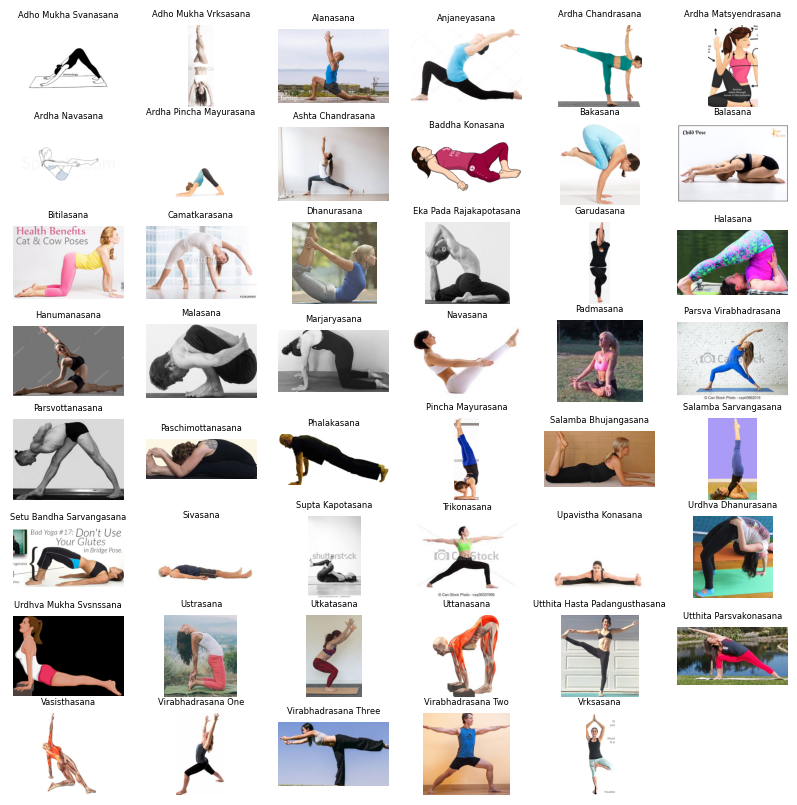

In [26]:
# Visualize some of the images
plt.figure(figsize = (10,10))

for index, label in enumerate(os.listdir(image_path)):

  image_list = os.listdir(os.path.join(image_path,label))

  # Display random images from the list
  random_images = random.choice(image_list)
  random_images = Image.open(os.path.join(image_path,label, random_images))

  # Plot
  plt.subplot(8,6,index+1)
  plt.imshow(random_images)
  plt.title(label,fontsize=6)
  plt.grid('off')
  plt.axis('off')

plt.show()

In [27]:
# Filtering out images that don't have the extensions we want -> I already ran this so we don't have to run this cell again
# image_extensions = ['jpg', 'jpeg', 'png']
# count = 0
# # Iterate through each subfolder and validate the extensions
# for directories in os.listdir(image_path):
#   for images in os.listdir(os.path.join(image_path,directories)):
#     path = os.path.join(image_path, directories, images)
#     try:
#       img = cv2.imread(path)
#       imgtype = imghdr.what(path)
#       if imgtype not in image_extensions:
#         print(f"{path} does not have the correct extensions")
#         os.remove(path)
#     except Exception as e:
#       print(f"Please check path of: {path}")
#   count +=1
#   print(count)

### Calculations

In [28]:
model = YOLO("yolov8n-pose.pt")

global find_angles 

kp_list = [(6, 8, 10, 'R-A'),(5, 7, 9, 'L-A'),(6, 12, 14, 'R-H'),(5, 11, 13, 'L-H'),
                                   (11, 13, 15, 'L-K'), (12, 14, 16, 'R-K'), (8, 6, 5, 'R-S'), (7, 5, 6, 'L-S')]

gym_object = YogAI()  # init AI GYM module
gym_object.set_params(line_thickness=2,
                    view_frame=True,
                    yoga_pose="standing",
                    kp_check=kp_list)

folder_paths = ("./Virabhadrasana_Two/left", 
                "./Virabhadrasana_Two/right", 
                "./Upavistha_Konasana", 
                "./Adho_Mukha_Svanasana/left",
                "./Adho_Mukha_Svanasana/right")

def get_yoga_range(path):
    global find_angles
    find_angles = []
    file_names = (f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)))

    angles = pd.DataFrame({'A' : []})
   

    for fname in file_names:
        try:
            full_name = path + '/' + fname
            im0 = cv.imread(full_name)
            results = model.predict(im0, verbose=False)
            temp = gym_object.find_pose(im0, results, 1, full_name)
            find_angles = temp
            if not angles.empty:
                angles = pd.concat([angles, temp], ignore_index=True)
            else:
                angles = temp
        except:
            pass

        
    ranges = {}
    deets = angles.describe()
    
    for angle in deets.columns:
        r =  (deets[angle]['mean'] - 2 * deets[angle]['std'], deets[angle]['mean'] + 2 * deets[angle]['std'])
        ranges[angle] = r
        
    return ranges
    
    

Virabhadrasana_Two_left = get_yoga_range(folder_paths[0])
Virabhadrasana_Two_right = get_yoga_range(folder_paths[1])
Upavistha_Konasana = get_yoga_range(folder_paths[2])
Adho_Mukha_Svanasana_left = get_yoga_range(folder_paths[3])
Adho_Mukha_Svanasana_right= get_yoga_range(folder_paths[4])

In [29]:
Virabhadrasana_Two_right

{'R-A': (145.20548922411814, 190.8990460623196),
 'L-A': (119.65277644340277, 177.32132951263605),
 'R-H': (97.19231603047089, 159.58115901753249),
 'L-H': (85.94347766984592, 138.0462787263075),
 'L-K': (67.59999845695957, 187.03397957495548),
 'R-K': (147.74158579286222, 190.47415686791305),
 'R-S': (154.6376426224466, 188.0280685499501),
 'L-S': (158.96767589773575, 186.78257620649228)}

In [30]:
Virabhadrasana_Two_left

{'R-A': (134.72181760261157, 194.2383368978392),
 'L-A': (136.5617429535768, 186.35974433116917),
 'R-H': (96.05767786882447, 138.10750656754257),
 'L-H': (101.79141298969343, 149.21051213980985),
 'L-K': (149.7792467197921, 179.0720192653026),
 'R-K': (114.87883066412137, 156.62342368178184),
 'R-S': (159.06276026833967, 184.63315245287322),
 'L-S': (159.77062943479564, 183.4107871019836)}

In [31]:
Adho_Mukha_Svanasana_right

{'R-A': (99.54169468093207, 180.58494254126012),
 'L-A': (145.8266174025256, 195.42897526055023),
 'R-H': (94.32419002727046, 108.34662668611641),
 'L-H': (65.09829256523162, 112.04490386109683),
 'L-K': (141.2602094754612, 181.9017886045223),
 'R-K': (143.94436492636623, 191.7562417149274),
 'R-S': (-2.103492860574285, 78.66989979603889),
 'L-S': (86.12380980530325, 118.5426105986429)}

# Running the Code

In [32]:
# Load YOLO model
model = YOLO("yolov8n-pose.pt")

# Grab the camera
cap = cv.VideoCapture(0)

if not cap.isOpened():
    print("Error opening camera")
    exit(0)

pose = YogAI()  # init AI GYM module
pose.set_params(line_thickness=2,
                    view_frame=True,
                    yoga_pose="Upavistha_Konasana",
                    kp_check=kp_list)

In [33]:
# Display
frame_count = 0
while True:
    # Capture frame-by-frame
    success, frame = cap.read()
    if not success:
        print("Error reading frame")
        break

    frame_count += 1

    # Perform YOLO prediction on the current frame
    results = model.predict(frame, verbose=False)

    # Finding the angles
    kp_angles = pose.find_pose(frame,results,frame_count,"Upavistha_Konasana")
    kp_angles = kp_angles.drop('img',axis=1)

    # Process the frame with the AI GYM module
    video, _ = pose.calibration(frame, kp_angles, Virabhadrasana_Two_right, results, frame_count)

    # Show
    cv.imshow('Yoga Poses', video)

    # Break the loop if 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv.destroyAllWindows()

### Gradio

In [36]:
def veedio(pose_type,image):
    model = YOLO("yolov8n-pose.pt")
    pose = YogAI()  # init AI GYM module
    pose.set_params(line_thickness=2,
                    view_frame=True,
                    yoga_pose=pose_type,
                    kp_check=kp_list)
    
        # Perform YOLO prediction on the current frame
    results = model.predict(image, verbose=False)

    # Finding the angles
    kp_angles = pose.find_pose(image,results,1,pose_type)
    kp_angles = kp_angles.drop('img',axis=1)


    # Yeah, if you can think of a better solution for this...
    if pose_type=='Virabhadrasana_Two_left':
        pose_type = Virabhadrasana_Two_left
    elif pose_type=='Virabhadrasana_Two_right':
        pose_type = Virabhadrasana_Two_right
    elif pose_type == 'Upavistha_Konasana':
        pose_type = Upavistha_Konasana
    elif pose_type == 'Adho_Mukha_Svanasana_left':
        pose_type = Adho_Mukha_Svanasana_left
    elif pose_type =='Adho_Mukha_Svanasana_right':
        pose_type = Adho_Mukha_Svanasana_right
    else:
        pose_type = Virabhadrasana_Two_left # default

    # Process the frame with the AI GYM module
    video,text = pose.calibration(image, kp_angles, pose_type, results, 1)
    
    return video,text

webapp = gradio.Interface(veedio,['text',gradio.Image(sources=["webcam"])],["image","text"])

webapp.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
